In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline
from sklearn import preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

idx = pd.IndexSlice


## Data

### Load all data

In [2]:
# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True)

# google trends
df_trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = df_trends.columns.levels[0].tolist()

df_gdp = eumf_data.read_gdp()
df_unempl = eumf_data.read_unempl()


### Join data, combine countries

In [3]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]



10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

### Compare keywords

In [5]:
### TRAINING

feature_combinations = [[k] for k in keyword_ids]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}
# params = {
#     "randomforestregressor__max_features": ["auto", "sqrt"],
#     "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
#     "randomforestregressor__min_samples_split": [2, 4, 8, 16],
# }

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
        cv=cv_default
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [6]:
eumf_eval.agg_multiple_cv_scores(
    cv_scores, feature_combinations, use_quantiles=False
).sort_values(("test_r2_mod", "mean"), ascending=False)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
          mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['19']    0.262   0.017  0.006    0.013    1.272e-03  4.498e-04  -0.099   0.035  0.012   -0.149   0.050  0.018          -0.117          0.529  0.187     0.049    0.603  0.213      0.028      0.041  0.014
['123']   0.380   0.031  0.011    0.018    3.510e-03  1.241e-03  -0.134   0.050  0.018   -0.181   0.067  0.024          -0.218          0.311  0.110    -0.300    0.639  0.226     -0.007      0.032  0.011
['119']   0.337   0.085  0.030    0.014    2.717e-03  9.605e-04  -0.135   0.055  0.019   -0.185   0.069  0.024          -0.270          0.267  0.094    -0.331    0.568  0.201     -0.009      0.026  0.009
['24']    0.303   0.013  0.005    0.016    3.635e-03  1.285e-03  -0.132   0.047  0.017   -0.189   0.064  0.023          -0.438          0.467  0.165    -0.447    0.770  0.272     -0.006      0.028  0.010
['114']   0.368   0.094  0.033    0.014    1.535e-03  5.428e-04  -0.137   0.050  0.018   -0.188   0.065  0.023          -0.365          0.351  0.124    -0.455    0.814  0.288     -0.010      0.033  0.012
['12']    0.252   0.032  0.011    0.016    3.611e-03  1.277e-03  -0.131   0.047  0.017   -0.189   0.065  0.023          -0.480          0.639  0.226    -0.490    0.878  0.311     -0.004      0.030  0.011
['118']   0.333   0.046  0.016    0.015    2.909e-03  1.029e-03  -0.130   0.044  0.016   -0.184   0.052  0.018          -0.333          0.630  0.223    -0.545    1.028  0.363     -0.003      0.042  0.015
['112']   0.378   0.035  0.012    0.015    1.527e-03  5.400e-04  -0.146   0.048  0.017   -0.196   0.063  0.022          -0.261          0.282  0.100    -0.577    0.820  0.290     -0.019      0.035  0.012
['39']    0.169   0.011  0.004    0.011    4.783e-04  1.691e-04  -0.138   0.050  0.018   -0.191   0.063  0.022          -0.319          0.448  0.159    -0.585    1.030  0.364     -0.011      0.037  0.013
['28']    0.193   0.026  0.009    0.015    2.545e-03  8.997e-04  -0.135   0.050  0.018   -0.192   0.065  0.023          -0.399          0.671  0.237    -0.613    1.069  0.378     -0.008      0.038  0.013
['49']    0.257   0.043  0.015    0.012    8.166e-04  2.887e-04  -0.138   0.049  0.017   -0.194   0.066  0.023          -0.353          0.506  0.179    -0.622    1.051  0.371     -0.012      0.037  0.013
['124']   0.380   0.119  0.042    0.015    2.353e-03  8.320e-04  -0.145   0.054  0.019   -0.201   0.072  0.025          -0.439          0.382  0.135    -0.625    0.859  0.304     -0.018      0.029  0.010
['122']   0.357   0.096  0.034    0.014    2.112e-03  7.467e-04  -0.145   0.051  0.018   -0.198   0.066  0.023          -0.280          0.224  0.079    -0.632    0.882  0.312     -0.018      0.037  0.013
['44']    0.189   0.019  0.007    0.011    3.044e-04  1.076e-04  -0.141   0.049  0.017   -0.199   0.067  0.024          -0.378          0.433  0.153    -0.655    0.944  0.334     -0.014      0.032  0.011
['117']   0.383   0.095  0.034    0.021    1.651e-02  5.836e-03  -0.141   0.045  0.016   -0.197   0.062  0.022          -0.434          0.460  0.163    -0.658    1.036  0.366     -0.014      0.039  0.014
['14']    0.285   0.058  0.021    0.015    3.034e-03  1.073e-03  -0.144   0.048  0.017   -0.202   0.067  0.024          -0.412          0.291  0.103    -0.664    0.860  0.304     -0.018      0.029  0.010
['21']    0.347   0.103  0.036    0.015    2.188e-03  7.737e-04  -0.143   0.051  0.018   -0.200   0.067  0.024          -0.493          0.492  0.174    -0.682    0.986  0.349     -0.016      0.031  0.011
['48']    0.200   0.018  0.006    0.012    3.700e-04  1.308e-04  -0.142   0.049  0.017   -0.199   0.067  0.024          -0.425      

In [7]:
eumf_eval.agg_multiple_cv_scores(
    cv_scores, feature_combinations, use_quantiles=True
).sort_values(("test_r2_mod", 0.5), ascending=False)


fit_time               score_time               test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae                  
          0.25    0.50   0.75     0.25     0.50   0.75    0.25    0.50   0.75     0.25    0.50   0.75            0.25           0.50   0.75      0.25     0.50   0.75       0.25       0.50     0.75   
['19']    0.254   0.265  0.272    0.012    0.012  0.014  -0.111  -0.098 -0.075   -0.176  -0.147 -0.104          -0.277          0.024  0.259    -0.184    0.276  0.417     -0.007      0.023  4.510e-02
['12']    0.236   0.246  0.260    0.013    0.014  0.018  -0.137  -0.126 -0.107   -0.218  -0.193 -0.150          -0.846         -0.405 -0.049    -1.284    0.035  0.148     -0.029     -0.003  1.946e-02
['28']    0.176   0.179  0.210    0.013    0.014  0.015  -0.143  -0.135 -0.105   -0.222  -0.191 -0.162          -0.690         -0.195  0.030    -1.533    0.024  0.184     -0.040      0.002  1.842e-02
['49']    0.224   0.246  0.285    0.012    0.012  0.012  -0.151  -0.139 -0.119   -0.223  -0.206 -0.163          -0.728         -0.203 -0.059    -1.582    0.017  0.123     -0.034     -0.009  1.447e-02
['24']    0.294   0.303  0.309    0.014    0.014  0.017  -0.142  -0.129 -0.106   -0.225  -0.192 -0.148          -0.675         -0.523 -0.046    -1.145   -0.045  0.175     -0.027     -0.011  1.627e-02
['48']    0.186   0.197  0.207    0.012    0.012  0.012  -0.155  -0.139 -0.115   -0.234  -0.198 -0.161          -0.714         -0.298 -0.031    -1.684   -0.071  0.109     -0.045     -0.007  9.316e-03
['20']    0.200   0.215  0.246    0.012    0.014  0.016  -0.159  -0.144 -0.117   -0.232  -0.203 -0.164          -0.632         -0.310 -0.053    -1.711   -0.113  0.117     -0.040     -0.009  6.968e-03
['2']     0.213   0.234  0.256    0.014    0.015  0.017  -0.163  -0.143 -0.112   -0.237  -0.203 -0.164          -0.680         -0.277 -0.051    -1.794   -0.117  0.082     -0.046     -0.012  1.055e-02
['16']    0.181   0.192  0.197    0.013    0.013  0.015  -0.157  -0.144 -0.110   -0.230  -0.200 -0.166          -0.717         -0.347 -0.024    -1.757   -0.134  0.132     -0.044     -0.010  7.385e-03
['57']    0.221   0.241  0.255    0.011    0.012  0.013  -0.171  -0.139 -0.120   -0.229  -0.212 -0.171          -0.917         -0.317 -0.065    -2.140   -0.136  0.068     -0.052     -0.008  8.758e-03
['44']    0.176   0.187  0.194    0.011    0.011  0.011  -0.154  -0.139 -0.118   -0.229  -0.205 -0.157          -0.643         -0.288 -0.125    -1.590   -0.137  0.075     -0.037     -0.012  6.268e-03
['15']    0.201   0.210  0.218    0.014    0.014  0.015  -0.159  -0.142 -0.112   -0.227  -0.202 -0.171          -0.754         -0.268 -0.006    -1.849   -0.149  0.151     -0.046     -0.007  7.331e-03
['41']    0.174   0.181  0.200    0.011    0.012  0.012  -0.179  -0.150 -0.114   -0.237  -0.216 -0.183          -1.013         -0.351 -0.027    -2.260   -0.149  0.043     -0.054     -0.010  8.511e-03
['32']    0.187   0.202  0.218    0.013    0.014  0.017  -0.156  -0.136 -0.121   -0.226  -0.205 -0.162          -0.622         -0.267 -0.069    -1.714   -0.156  0.100     -0.043     -0.012  1.304e-02
['21']    0.290   0.316  0.357    0.014    0.015  0.017  -0.162  -0.143 -0.109   -0.235  -0.207 -0.147          -0.758         -0.389 -0.114    -1.633   -0.157  0.074     -0.036     -0.015  3.486e-03
['59']    0.158   0.161  0.177    0.011    0.011  0.011  -0.165  -0.149 -0.113   -0.235  -0.207 -0.167          -0.694         -0.304 -0.059    -1.871   -0.159  0.096     -0.046     -0.013  5.510e-03
['125']   0.273   0.296  0.391    0.013    0.014  0.018  -0.161  -0.155 -0.117   -0.225  -0.196 -0.173          -0.505         -0.273 -0.022    -1.857   -0.173  0.069     -0.057     -0.010  6.254e-03
['117']   0.320   0.366  0.414    0.013    0.015  0.018  -0.164  -0.142 -0.120   -0.232  -0.221 -0.154          -0.490         -0.247 -0.188    -1.288   -0.179  0.082     -0.034     -0.017  1.014e-02
['39']  

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
df_to_plot = (
    pd.concat(
        {int(f[0]): c for f, c in zip(feature_combinations, cv_scores)},
        names=["keyword group"],
    )
    .reset_index()
    .sort_values(by="keyword group")
)
plt.axhline(0.0, c="lightgrey")
sns.pointplot(
    data=df_to_plot,
    y="test_r2_mod",
    x="keyword group",
    ci=95,
    join=False,
    estimator=np.median,
)
plt.ylabel(r"$R^2_{oos}$")
plt.xticks(rotation="45")
plt.show()


ValueError: invalid literal for int() with base 10: 'gdp'

### Same, but limit countries

In [9]:
### TRAINING

feature_combinations = [[k] for k in keyword_ids]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}
# params = {
#     "randomforestregressor__max_features": ["auto", "sqrt"],
#     "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
#     "randomforestregressor__min_samples_split": [2, 4, 8, 16],
# }

country_selection = ["ES", "IT", "PT", "GR"]

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


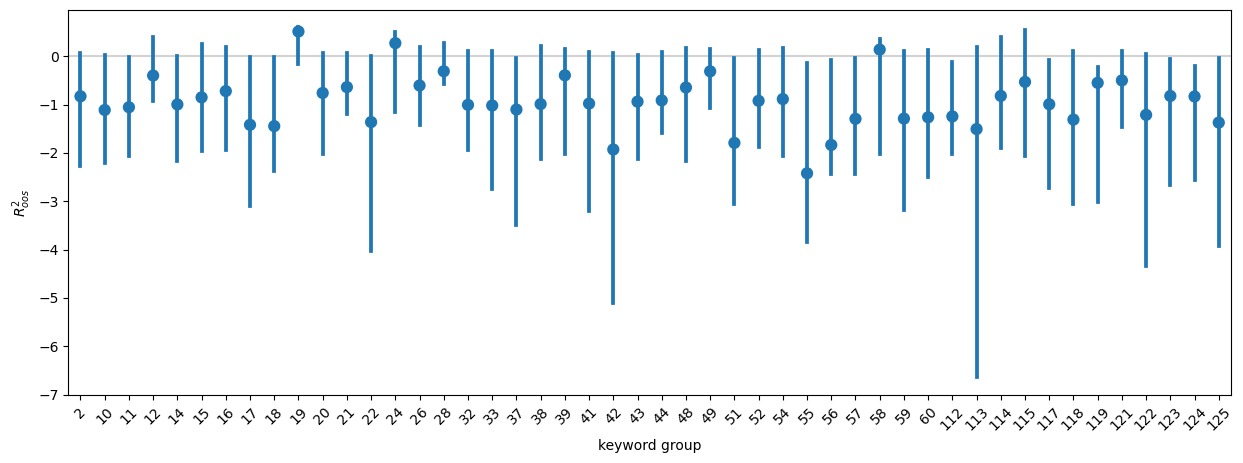

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
df_to_plot = (
    pd.concat(
        {int(f[0]): c for f, c in zip(feature_combinations, cv_scores)},
        names=["keyword group"],
    )
    .reset_index()
    .sort_values(by="keyword group")
)
plt.axhline(0.0, c="lightgrey")
sns.pointplot(
    data=df_to_plot,
    y="test_r2_mod",
    x="keyword group",
    ci=95,
    join=False,
    estimator=np.median,
)
plt.ylabel(r"$R^2_{oos}$")
plt.xticks(rotation="45")
plt.show()


In [11]:
eumf_eval.agg_multiple_cv_scores(
    cv_scores, feature_combinations, use_quantiles=False
).sort_values(("test_r2_mod", "mean"), ascending=False)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
          mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['19']    0.107   0.008  0.003    0.012    8.870e-04  3.136e-04  -0.103   0.055  0.020   -0.129   0.061  0.021           0.069          0.524  0.185     0.355    0.396  0.140      0.072      0.097  0.034
['28']    0.091   0.005  0.002    0.012    1.959e-03  6.926e-04  -0.161   0.084  0.030   -0.194   0.098  0.035          -0.409          0.624  0.221    -0.351    0.892  0.315      0.014      0.061  0.022
['24']    0.100   0.006  0.002    0.011    6.575e-04  2.325e-04  -0.144   0.077  0.027   -0.183   0.091  0.032          -0.869          1.321  0.467    -0.456    1.490  0.527      0.031      0.070  0.025
['49']    0.112   0.010  0.003    0.012    9.519e-04  3.365e-04  -0.177   0.085  0.030   -0.208   0.090  0.032          -0.401          0.477  0.169    -0.501    0.778  0.275     -0.002      0.057  0.020
['12']    0.096   0.007  0.002    0.011    5.648e-04  1.997e-04  -0.176   0.089  0.032   -0.207   0.102  0.036          -0.367          0.572  0.202    -0.626    1.200  0.424     -0.001      0.056  0.020
['26']    0.095   0.006  0.002    0.011    5.382e-04  1.903e-04  -0.195   0.095  0.034   -0.220   0.104  0.037          -0.389          0.460  0.163    -0.661    0.807  0.285     -0.020      0.048  0.017
['58']    0.120   0.017  0.006    0.013    7.293e-04  2.579e-04  -0.184   0.097  0.034   -0.212   0.102  0.036          -0.327          0.648  0.229    -0.698    1.716  0.607     -0.009      0.069  0.024
['21']    0.106   0.017  0.006    0.011    5.359e-04  1.895e-04  -0.197   0.092  0.033   -0.223   0.097  0.034          -0.453          0.585  0.207    -0.735    0.953  0.337     -0.022      0.045  0.016
['114']   0.104   0.006  0.002    0.011    5.699e-04  2.015e-04  -0.187   0.092  0.033   -0.217   0.094  0.033          -0.530          0.747  0.264    -0.770    1.013  0.358     -0.012      0.055  0.019
['44']    0.102   0.006  0.002    0.012    7.838e-04  2.771e-04  -0.202   0.087  0.031   -0.231   0.099  0.035          -0.216          0.416  0.147    -0.825    0.872  0.308     -0.027      0.051  0.018
['16']    0.095   0.007  0.003    0.012    1.966e-03  6.951e-04  -0.196   0.094  0.033   -0.227   0.104  0.037          -0.253          0.579  0.205    -0.870    1.087  0.384     -0.021      0.042  0.015
['52']    0.105   0.006  0.002    0.012    4.145e-04  1.465e-04  -0.194   0.095  0.034   -0.229   0.099  0.035          -0.596          0.526  0.186    -0.902    1.015  0.359     -0.019      0.044  0.015
['48']    0.116   0.010  0.004    0.015    2.117e-03  7.483e-04  -0.202   0.092  0.032   -0.228   0.100  0.036          -0.355          0.774  0.274    -0.910    1.205  0.426     -0.027      0.051  0.018
['15']    0.092   0.006  0.002    0.011    5.908e-04  2.089e-04  -0.193   0.082  0.029   -0.224   0.097  0.034          -0.524          0.542  0.191    -0.917    1.183  0.418     -0.018      0.067  0.024
['115']   0.101   0.007  0.002    0.011    5.760e-04  2.037e-04  -0.187   0.099  0.035   -0.222   0.110  0.039          -0.923          0.965  0.341    -0.919    1.429  0.505     -0.012      0.093  0.033
['20']    0.094   0.006  0.002    0.011    5.510e-04  1.948e-04  -0.206   0.088  0.031   -0.233   0.099  0.035          -0.176          0.410  0.145    -0.920    0.998  0.353     -0.031      0.045  0.016
['39']    0.110   0.015  0.005    0.012    6.711e-04  2.373e-04  -0.201   0.086  0.030   -0.231   0.094  0.033          -0.620          0.744  0.263    -0.947    1.232  0.436     -0.026      0.052  0.018
['54']    0.099   0.007  0.002    0.012    3.357e-04  1.187e-04  -0.207   0.089  0.032   -0.236   0.102  0.036          -0.333      

### Permutate best

In [12]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "123"],
    ["19", "58"],
    ["19", "118"],
    ["19", "12"],
    ["19", "28"],
    ["19", "112"],
    ["19", "39"],
    ["19", "24"],
    ["19", "119"],
    ["19", "16"],
    ["19", "114"],
    ["19", "49"],
    ["19", "115"],
    ["19", "48"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}
# params = {
#     "randomforestregressor__max_features": ["auto", "sqrt"],
#     "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
#     "randomforestregressor__min_samples_split": [2, 4, 8, 16],
# }

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [13]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_mae", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['19', '123']   0.387   0.021  0.007    0.016    7.500e-03  2.652e-03  -0.094   0.034  0.012   -0.140   0.050  0.018         8.342e-02        0.383  0.135     0.192    0.451  0.160      0.033      0.041  0.015
['19', '115']   0.342   0.022  0.008    0.012    4.360e-04  1.541e-04  -0.095   0.031  0.011   -0.141   0.048  0.017         4.938e-02        0.357  0.126     0.163    0.477  0.169      0.031      0.046  0.016
['19', '114']   0.351   0.038  0.014    0.012    3.343e-04  1.182e-04  -0.096   0.027  0.009   -0.145   0.043  0.015        -3.643e-02        0.418  0.148     0.094    0.535  0.189      0.030      0.047  0.017
['19', '118']   0.390   0.025  0.009    0.013    1.283e-03  4.535e-04  -0.097   0.029  0.010   -0.142   0.041  0.014        -6.247e-02        0.548  0.194     0.082    0.620  0.219      0.030      0.045  0.016
['19', '112']   0.367   0.028  0.010    0.012    4.833e-04  1.709e-04  -0.097   0.028  0.010   -0.143   0.045  0.016         1.405e-02        0.346  0.122     0.142    0.464  0.164      0.030      0.046  0.016
['19', '119']   0.335   0.019  0.007    0.011    2.398e-04  8.479e-05  -0.098   0.036  0.013   -0.145   0.049  0.017         2.219e-04        0.426  0.151     0.101    0.510  0.180      0.029      0.040  0.014
['19', '49']    0.337   0.016  0.006    0.012    6.583e-04  2.327e-04  -0.098   0.036  0.013   -0.149   0.051  0.018        -1.061e-01        0.507  0.179     0.063    0.582  0.206      0.029      0.040  0.014
['19', '48']    0.356   0.030  0.011    0.014    2.616e-03  9.250e-04  -0.098   0.035  0.012   -0.148   0.050  0.018        -1.081e-01        0.531  0.188     0.059    0.600  0.212      0.029      0.041  0.015
['19', '39']    0.351   0.049  0.017    0.014    2.529e-03  8.943e-04  -0.098   0.030  0.010   -0.149   0.044  0.016        -8.971e-02        0.398  0.141     0.049    0.522  0.185      0.029      0.044  0.016
['19', '58']    0.348   0.017  0.006    0.013    2.203e-03  7.788e-04  -0.098   0.033  0.012   -0.149   0.048  0.017        -8.157e-02        0.500  0.177     0.045    0.600  0.212      0.029      0.043  0.015
['19', '28']    0.305   0.018  0.007    0.013    4.068e-04  1.438e-04  -0.099   0.035  0.013   -0.149   0.050  0.018        -1.061e-01        0.508  0.180     0.057    0.584  0.207      0.028      0.040  0.014
['19']          0.288   0.069  0.024    0.013    1.948e-03  6.887e-04  -0.099   0.035  0.012   -0.149   0.050  0.018        -1.169e-01        0.529  0.187     0.049    0.603  0.213      0.028      0.041  0.014
['19', '16']    0.289   0.014  0.005    0.012    2.623e-04  9.272e-05  -0.099   0.035  0.012   -0.150   0.050  0.018        -1.183e-01        0.513  0.182     0.047    0.590  0.209      0.028      0.040  0.014
['19', '24']    0.334   0.018  0.006    0.011    1.443e-04  5.103e-05  -0.099   0.036  0.013   -0.148   0.049  0.017        -8.979e-02        0.464  0.164     0.085    0.537  0.190      0.027      0.038  0.014
['19', '12']    0.334   0.017  0.006    0.012    9.631e-04  3.405e-04  -0.100   0.034  0.012   -0.151   0.048  0.017        -1.672e-01        0.568  0.201     0.006    0.647  0.229      0.027      0.041  0.015

In [14]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "118"],
    ["19", "118", "115"],
    ["19", "118", "115", "123"],
    ["19", "118", "115", "123", "49"],
    ["19", "gdp", "unempl"],
    ["19", "118", "gdp", "unempl"],
    ["19", "118", "115", "gdp", "unempl"],
    ["19", "118", "115", "123", "gdp", "unempl"],
    ["19", "118", "115", "123", "49", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
    ["value", "19", "118", "115", "123", "49", "gdp", "unempl"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [15]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_rmse", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                                                     mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['value', '19', '118', '115', '123', '49', 'gdp...   0.461   0.032  0.011    0.011    2.530e-04  8.945e-05  -0.083   0.025  0.009   -0.123   0.046  0.016           0.325          0.136  0.048     0.432    0.209  0.074      0.043      0.051  0.018
['value', '19', 'gdp', 'unempl']                     0.287   0.019  0.007    0.011    4.875e-04  1.723e-04  -0.083   0.024  0.008   -0.123   0.047  0.017           0.320          0.138  0.049     0.434    0.199  0.071      0.044      0.053  0.019
['19', '118', '115', 'gdp', 'unempl']                0.154   0.013  0.005    0.012    8.357e-04  2.955e-04  -0.092   0.030  0.011   -0.132   0.050  0.018           0.230          0.170  0.060     0.327    0.289  0.102      0.035      0.047  0.017
['19', '118', '115', '123', '49', 'gdp', 'unempl']   0.177   0.013  0.005    0.012    4.515e-04  1.596e-04  -0.092   0.032  0.011   -0.132   0.050  0.018           0.244          0.164  0.058     0.331    0.269  0.095      0.034      0.045  0.016
['19', '118', '115', '123', 'gdp', 'unempl']         0.159   0.012  0.004    0.012    1.050e-03  3.712e-04  -0.095   0.034  0.012   -0.134   0.051  0.018           0.219          0.183  0.065     0.308    0.289  0.102      0.032      0.042  0.015
['19', '118', 'gdp', 'unempl']                       0.191   0.012  0.004    0.014    8.335e-04  2.947e-04  -0.094   0.031  0.011   -0.134   0.051  0.018           0.174          0.204  0.072     0.306    0.294  0.104      0.033      0.045  0.016
['19', 'gdp', 'unempl']                              0.131   0.013  0.004    0.012    6.427e-04  2.272e-04  -0.095   0.036  0.013   -0.136   0.056  0.020           0.191          0.164  0.058     0.322    0.245  0.087      0.032      0.041  0.015
['19', '118']                                        0.150   0.011  0.004    0.013    9.711e-04  3.433e-04  -0.092   0.029  0.010   -0.137   0.045  0.016           0.129          0.358  0.127     0.210    0.457  0.162      0.035      0.046  0.016
['19', '118', '115', '123', '49']                    0.171   0.012  0.004    0.012    6.657e-04  2.353e-04  -0.094   0.036  0.013   -0.138   0.052  0.018           0.179          0.309  0.109     0.228    0.417  0.148      0.032      0.043  0.015
['19', '118', '115', '123']                          0.175   0.012  0.004    0.013    7.279e-04  2.573e-04  -0.094   0.033  0.012   -0.139   0.048  0.017           0.136          0.397  0.140     0.184    0.496  0.175      0.032      0.045  0.016
['19']                                               0.181   0.015  0.005    0.013    1.996e-03  7.057e-04  -0.096   0.028  0.010   -0.140   0.045  0.016           0.061          0.437  0.155     0.163    0.531  0.188      0.031      0.047  0.017
['19', '118', '115']                                 0.363   0.021  0.007    0.011    3.017e-04  1.067e-04  -0.096   0.032  0.011   -0.140   0.044  0.016           0.002          0.452  0.160     0.129    0.553  0.196      0.031      0.045  0.016

### Same for selected countries

In [16]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "58"],
    ["19", "115"],
    ["19", "24"],
    ["19", "28"],
    ["19", "12"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

country_selection = ["ES", "IT", "PT", "GR"]

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [17]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_rmse", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['19', '115']   0.099   0.009  0.003    0.012    8.936e-04  3.159e-04  -0.097   0.059  0.021   -0.120   0.065  0.023           0.252          0.389  0.138     0.435    0.359  0.127      0.078      0.095  0.034
['19', '28']    0.103   0.009  0.003    0.013    9.640e-04  3.408e-04  -0.100   0.068  0.024   -0.123   0.075  0.026           0.188          0.369  0.130     0.441    0.340  0.120      0.075      0.093  0.033
['19']          0.090   0.010  0.004    0.012    9.324e-04  3.297e-04  -0.100   0.056  0.020   -0.125   0.060  0.021           0.137          0.469  0.166     0.429    0.328  0.116      0.075      0.094  0.033
['19', '12']    0.110   0.017  0.006    0.014    2.576e-03  9.108e-04  -0.103   0.062  0.022   -0.128   0.067  0.024           0.175          0.313  0.111     0.412    0.288  0.102      0.072      0.092  0.032
['19', '58']    0.094   0.009  0.003    0.012    1.052e-03  3.720e-04  -0.104   0.060  0.021   -0.129   0.064  0.023           0.195          0.311  0.110     0.377    0.357  0.126      0.071      0.093  0.033
['19', '24']    0.096   0.011  0.004    0.012    9.947e-04  3.517e-04  -0.105   0.060  0.021   -0.130   0.064  0.023           0.089          0.471  0.167     0.312    0.530  0.187      0.070      0.091  0.032

In [18]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "115"],
    ["19", "115", "28"],
    ["19", "115", "28", "12"],
    ["19", "115", "28", "12", "58"],
    ["19", "115", "28", "12", "58", "24"],
    ["gdp", "unempl", "19"],
    ["gdp", "unempl", "19", "115"],
    ["gdp", "unempl", "19", "115", "28"],
    ["gdp", "unempl", "19", "115", "28", "12"],
    ["gdp", "unempl", "19", "115", "28", "12", "58"],
    ["gdp", "unempl", "19", "115", "28", "12", "58", "24"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

country_selection = ["ES", "IT", "PT", "GR"]

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [19]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_rmse", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                                                     mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['19', '115']                                        0.098   0.010  0.004    0.012    1.190e-03  4.207e-04  -0.097   0.059  0.021   -0.120   0.065  0.023           0.252          0.389  0.138     0.435    0.359  0.127      0.078      0.095  0.034
['19', '115', '28', '12']                            0.102   0.011  0.004    0.012    8.564e-04  3.028e-04  -0.105   0.079  0.028   -0.125   0.087  0.031           0.269          0.321  0.113     0.430    0.362  0.128      0.070      0.090  0.032
['19']                                               0.092   0.008  0.003    0.012    1.155e-03  4.085e-04  -0.100   0.056  0.020   -0.125   0.060  0.021           0.137          0.469  0.166     0.429    0.328  0.116      0.075      0.094  0.033
['19', '115', '28']                                  0.094   0.010  0.004    0.012    7.472e-04  2.642e-04  -0.104   0.079  0.028   -0.126   0.088  0.031           0.239          0.356  0.126     0.427    0.324  0.114      0.071      0.093  0.033
['19', '115', '28', '12', '58']                      0.100   0.007  0.003    0.012    1.240e-03  4.383e-04  -0.107   0.078  0.028   -0.130   0.085  0.030           0.243          0.281  0.099     0.370    0.414  0.147      0.068      0.088  0.031
['19', '115', '28', '12', '58', '24']                0.106   0.013  0.005    0.012    1.126e-03  3.982e-04  -0.108   0.075  0.027   -0.132   0.081  0.029           0.193          0.342  0.121     0.343    0.442  0.156      0.067      0.087  0.031
['gdp', 'unempl', '19']                              0.096   0.012  0.004    0.012    1.228e-03  4.343e-04  -0.124   0.070  0.025   -0.144   0.077  0.027           0.300          0.204  0.072     0.248    0.474  0.168      0.051      0.092  0.033
['gdp', 'unempl', '19', '115', '28', '12', '58']     0.093   0.010  0.003    0.011    9.364e-04  3.311e-04  -0.126   0.074  0.026   -0.147   0.082  0.029           0.226          0.255  0.090     0.250    0.415  0.147      0.049      0.088  0.031
['gdp', 'unempl', '19', '115', '28']                 0.117   0.013  0.005    0.011    8.389e-04  2.966e-04  -0.124   0.071  0.025   -0.147   0.078  0.027           0.129          0.352  0.124     0.217    0.413  0.146      0.051      0.094  0.033
['gdp', 'unempl', '19', '115']                       0.092   0.010  0.003    0.012    7.540e-04  2.666e-04  -0.129   0.070  0.025   -0.148   0.076  0.027           0.251          0.238  0.084     0.194    0.489  0.173      0.046      0.091  0.032
['gdp', 'unempl', '19', '115', '28', '12', '58'...   0.131   0.013  0.005    0.011    6.819e-04  2.411e-04  -0.124   0.074  0.026   -0.148   0.081  0.029           0.149          0.320  0.113     0.203    0.464  0.164      0.051      0.092  0.033
['gdp', 'unempl', '19', '115', '28', '12']           0.123   0.014  0.005    0.011    7.201e-04  2.546e-04  -0.125   0.074  0.026   -0.149   0.081  0.029           0.115          0.360  0.127     0.198    0.430  0.152      0.050      0.093  0.033

In [20]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "115", "28", "12"],
    ["gdp", "unempl", "19"],
    ["gdp", "unempl", "19", "115", "28", "12"],
    ["value", "19"],
    ["value", "19", "115", "28", "12"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

country_selection = ["ES", "IT", "PT", "GR"]

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [21]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_rmse", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                                             mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['value', '19']                              0.102   0.012  0.004    0.011    1.001e-03  3.539e-04  -0.100   0.057  0.020   -0.123   0.058  0.021           0.208          0.430  0.152     0.391    0.428  0.151      0.075      0.096  0.034
['19', '115', '28', '12']                    0.116   0.008  0.003    0.015    2.615e-03  9.247e-04  -0.105   0.079  0.028   -0.125   0.087  0.031           0.269          0.321  0.113     0.430    0.362  0.128      0.070      0.090  0.032
['19']                                       0.091   0.010  0.004    0.012    1.418e-03  5.012e-04  -0.100   0.056  0.020   -0.125   0.060  0.021           0.137          0.469  0.166     0.429    0.328  0.116      0.075      0.094  0.033
['value', '19', '115', '28', '12']           0.098   0.010  0.004    0.012    8.353e-04  2.953e-04  -0.112   0.081  0.029   -0.132   0.086  0.030           0.269          0.304  0.107     0.354    0.403  0.142      0.063      0.095  0.034
['gdp', 'unempl', '19']                      0.089   0.008  0.003    0.011    6.663e-04  2.356e-04  -0.124   0.070  0.025   -0.144   0.077  0.027           0.300          0.204  0.072     0.248    0.474  0.168      0.051      0.092  0.033
['gdp', 'unempl', '19', '115', '28', '12']   0.123   0.012  0.004    0.011    7.554e-04  2.671e-04  -0.125   0.074  0.026   -0.149   0.081  0.029           0.115          0.360  0.127     0.198    0.430  0.152      0.050      0.093  0.033

In [22]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "115", "28", "12"],
    ["gdp", "unempl", "19"],
    ["gdp", "unempl", "19", "115", "28", "12"],
    ["value", "19"],
    ["value", "19", "115", "28", "12"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

country_selection = ["PL", "CZ+SK", "HU", "LV+LT+EE"]

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [23]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_rmse", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                                             mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['gdp', 'unempl', '19']                      0.090   0.009  0.003    0.011    8.250e-04  2.917e-04  -0.098   0.076  0.027   -0.117   0.081  0.028           0.250          0.436  0.154     0.105    0.421  0.149      0.020      0.028  0.010
['gdp', 'unempl', '19', '115', '28', '12']   0.092   0.010  0.004    0.012    9.900e-04  3.500e-04  -0.100   0.084  0.030   -0.118   0.089  0.031           0.296          0.391  0.138     0.175    0.331  0.117      0.018      0.020  0.007
['value', '19']                              0.106   0.011  0.004    0.011    9.575e-04  3.385e-04  -0.107   0.082  0.029   -0.125   0.085  0.030          -0.062          0.872  0.308    -0.083    0.804  0.284      0.011      0.027  0.009
['value', '19', '115', '28', '12']           0.129   0.010  0.003    0.011    5.242e-04  1.853e-04  -0.111   0.087  0.031   -0.129   0.090  0.032          -0.190          1.108  0.392    -0.182    1.047  0.370      0.007      0.028  0.010
['19']                                       0.100   0.012  0.004    0.012    1.079e-03  3.815e-04  -0.115   0.089  0.031   -0.131   0.093  0.033          -0.012          0.349  0.123    -0.032    0.360  0.127      0.003      0.020  0.007
['19', '115', '28', '12']                    0.090   0.010  0.003    0.012    1.438e-03  5.083e-04  -0.116   0.099  0.035   -0.131   0.103  0.036           0.111          0.328  0.116    -0.044    0.469  0.166      0.002      0.027  0.010

In [24]:
### TRAINING

feature_combinations = [
    ["19"],
    ["19", "115", "28", "12"],
    ["gdp", "unempl", "19"],
    ["gdp", "unempl", "19", "115", "28", "12"],
    ["value", "19"],
    ["value", "19", "115", "28", "12"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

country_selection = ["HR", "SI", "BG", "RO"]

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=features,
        lags=[1, 2, 3, 4, 5, 6],
        alternate_lags={
            "value": [2, 3, 4, 5, 6],
            "gdp": [2, 3, 4, 5, 6],
            "unempl": [2, 3, 4, 5, 6],
        },
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [25]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations).sort_values(
    ("test_rmse", "mean"), ascending=False
)


fit_time               score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                                             mean    std    sem      mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['value', '19', '115', '28', '12']           0.119   0.011  0.004    0.012    9.155e-04  3.237e-04  -0.137   0.069  0.025   -0.195   0.114  0.040           0.246          0.340  0.120     0.227    0.821  0.290      0.053      0.084  0.030
['gdp', 'unempl', '19', '115', '28', '12']   0.095   0.010  0.004    0.012    1.031e-03  3.644e-04  -0.147   0.076  0.027   -0.196   0.106  0.038           0.146          0.192  0.068     0.320    0.449  0.159      0.043      0.045  0.016
['value', '19']                              0.130   0.015  0.005    0.015    2.184e-03  7.722e-04  -0.140   0.070  0.025   -0.199   0.114  0.040           0.171          0.369  0.130     0.195    0.794  0.281      0.050      0.083  0.029
['gdp', 'unempl', '19']                      0.159   0.020  0.007    0.020    5.150e-03  1.821e-03  -0.150   0.075  0.026   -0.201   0.104  0.037           0.059          0.167  0.059     0.252    0.487  0.172      0.040      0.044  0.015
['19', '115', '28', '12']                    0.112   0.011  0.004    0.011    9.535e-04  3.371e-04  -0.156   0.069  0.024   -0.224   0.107  0.038           0.072          0.355  0.125    -0.049    0.791  0.280      0.034      0.070  0.025
['19']                                       0.119   0.007  0.003    0.015    1.348e-03  4.765e-04  -0.165   0.062  0.022   -0.237   0.097  0.034          -0.178          0.338  0.120    -0.306    0.995  0.352      0.025      0.070  0.025